# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

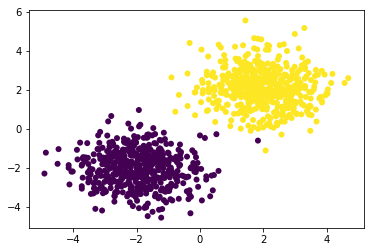

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



In [6]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

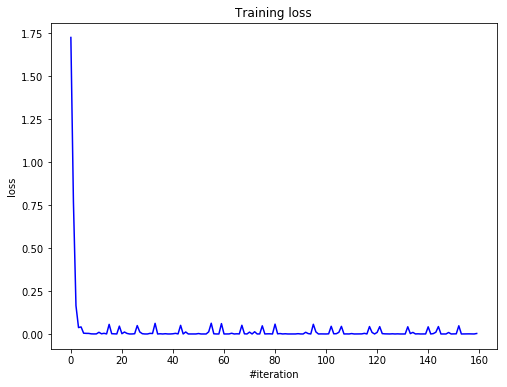

Current loss: 0.002814


In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [100]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [101]:
total = len(set(list(y_train) + list(y_test) + list(y_val)))
y_train = np.eye(total)[y_train]
print(y_train.shape)

(50000, 10)


In [30]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_val = X_val.reshape((X_val.shape[0], 28 * 28))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

I take the simplest one-layer linear model for faster training and less external (for activation) parameters for cleaner comparison of activations.

In [91]:
losses = {}
# Looping params
n_epoch = 40
batch_size = 256
for use_bn in [True, False]:
    for activation in [ReLU, ELU, LeakyReLU, SoftPlus]:
        net = Sequential()
        net.add(Linear(28 * 28, y_train.shape[1]))
        if use_bn:
            bl = BatchNormalization()
            bl.moving_mean = np.random.uniform(-1, 1, (y_train.shape[1])) 
            bl.moving_variance = np.random.uniform(-1, 1, (y_train.shape[1])) 
            net.add(bl)
            net.add(ChannelwiseScaling(y_train.shape[1]))
        net.add(activation())
        net.add(LogSoftMax())
        print(net)
        
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
        optimizer_state = {}
        loss_history = []
        for i in range(n_epoch):
            for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

                net.zeroGradParameters()

                # Forward
                predictions = net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)

                # Backward
                dp = criterion.backward(predictions, y_batch)
                net.backward(x_batch, dp)

                # Update weights
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)
        losses[(activation, use_bn)] = loss_history

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
ReLU
LogSoftMax

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
ELU
LogSoftMax

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
LeakyReLU
LogSoftMax

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
SoftPlus
LogSoftMax

Linear 784 -> 10
ReLU
LogSoftMax

Linear 784 -> 10
ELU
LogSoftMax

Linear 784 -> 10
LeakyReLU
LogSoftMax

Linear 784 -> 10
SoftPlus
LogSoftMax



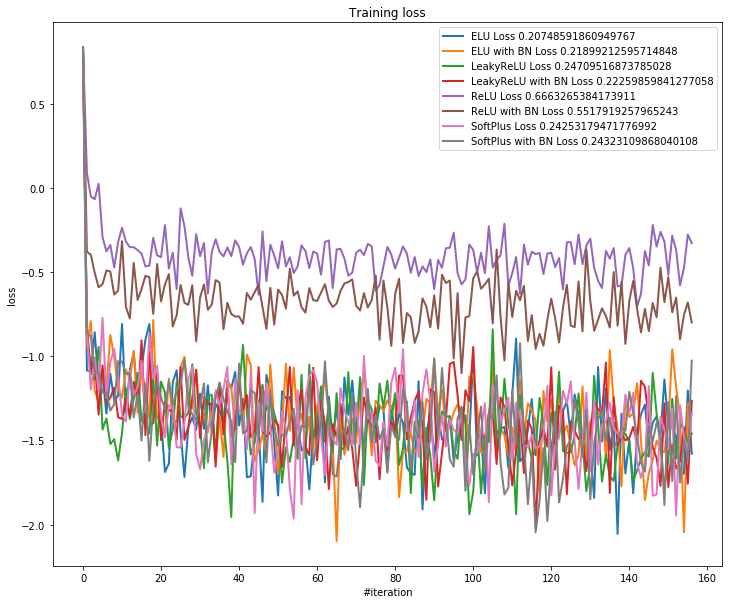

Current loss: 0.186893


In [92]:
plt.figure(figsize=(12, 10))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
for key, loss_history in sorted(losses.items(), key=lambda x: str(x[0][0]()) + str(x[0][1])):
    plt.plot(np.log(loss_history[::50]),
             label=str(key[0]()) + (" with BN" if key[1] else "") + " Loss " + str(np.mean(loss_history[-10:])), linewidth=2)
plt.legend()
plt.show()

print('Current loss: %f' % loss)    

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

BatchNormalization here in most cases doesn't make a big difference, but it's effect lags because we have more weights to train, than when we don't use it.

From all activations ELU was the best in all runs (and more often with BN even improving the quality). Also it's quick, so I take it for today's leader.

In [88]:
opt_losses = {}

n_epoch = 50
batch_size = 256
for opt in [(sgd_momentum, "sgd"), (adam_optimizer, "adam")]:
    net = Sequential()
    net.add(Linear(28 * 28, y_train.shape[1]))
    bl = BatchNormalization()
    bl.moving_mean = np.random.uniform(-1, 1, (y_train.shape[1])) 
    bl.moving_variance = np.random.uniform(-1, 1, (y_train.shape[1])) 
    net.add(bl)
    net.add(ChannelwiseScaling(y_train.shape[1]))
    net.add(ELU())
    net.add(LogSoftMax())
    print(net)

    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    if opt[1] == "adam":
        optimizer_config = {"learning_rate": 1e-1, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8}
    optimizer_state = {}
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            opt[0](net.getParameters(), 
                net.getGradParameters(), 
                optimizer_config,
                optimizer_state)      

            loss_history.append(loss)
    opt_losses[opt[1]] = loss_history

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
ELU
LogSoftMax

Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
ELU
LogSoftMax



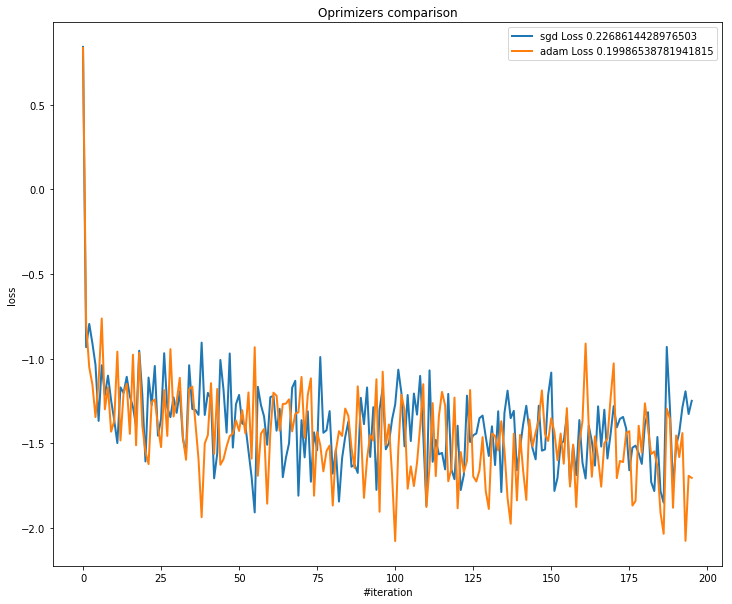

Current loss: 0.162912


In [89]:
plt.figure(figsize=(12, 10))

plt.title("Oprimizers comparison")
plt.xlabel("#iteration")
plt.ylabel("loss")
for key, loss_history in opt_losses.items():
    plt.plot(np.log(loss_history[::50]),
             label=key + " Loss " + str(np.mean(loss_history[-10:])), linewidth=2)
plt.legend()
plt.show()

print('Current loss: %f' % loss)  

Adam loss seems to generally go lower than the sgd one, but it's not a very big difference and anyway parameters tuning is required to day anything for shure:)

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [97]:
from tqdm import tqdm

n_epoch = 10
batch_size = 256

net = Sequential()
net.add(Linear(28 * 28, 512))
bl = BatchNormalization()
bl.moving_mean = np.random.uniform(-1, 1, (512)) 
bl.moving_variance = np.random.uniform(-1, 1, (512)) 
net.add(bl)
net.add(ChannelwiseScaling(512))
net.add(ELU())
net.add(Dropout(0.5))
net.add(Linear(512, 10))
net.add(ELU())
net.add(LogSoftMax())
print(net)

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
# if opt[1] == "adam":
#     optimizer_config = {"learning_rate": 1e-1, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8}
optimizer_state = {}
loss_history = []
for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      

  0%|          | 0/10 [00:00<?, ?it/s]

Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ELU
Dropout
Linear 512 -> 10
ELU
LogSoftMax



100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


In [98]:
net.evaluate()
preds = net.updateOutput(X_test)
preds = np.argmax(preds, axis=1)

Print here your accuracy on test set. It should be around 90%.

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.957